<style>
.rendered_html * + p, .rendered_html p {
    text-align:justify;
}
.print {
    display:none;
}
.highlight {
    background:white;
}
@media print {
 a[href]:after {
     content: ""
 }
 .noprint {
  display:none
  }
  .print {
        display:block;
    }
}
</style>
<head>
    <base target="_blank">
</head>
<div style="text-align:left"><a href="http://web.dmi.unict.it/"><img src="img/dmi.png" style="width:300px; margin:0;"></a></div>

<a href="http://iplab.dmi.unict.it/"><img src="img/iplab.png" style="width:900px"></a>
<center><h2>Machine Learning - A.A. 2020-2021</h2></center>
<center><h3>Regressione Lineare in Pytorch, API ad oggetti di Pytorch, Monitoring del training mediante Tensorboard</h3></center>
<br>
<center>Antonino Furnari - <a href="http://www.dmi.unict.it/~furnari/" target="_blank">http://www.dmi.unict.it/~furnari/</a> - <a href="mailto:furnari@dmi.unict.it">furnari@dmi.unict.it</a> </center>
<center>Giovanni Maria Farinella - <a href="http://www.dmi.unict.it/farinella/" target="_blank">http://www.dmi.unict.it/farinella/</a> - <a href="mailto:gfarinella@dmi.unict.it">gfarinella@dmi.unict.it</a> </center>

# 1 Regressione Lineare in PyTorch

In questo laboratorio vediamo come costruire e allenare un regressore lineare in PyTorch. Carichiamo il dataset "Boston" mediante **scikit-learn** e visualizziamone la descrizione:

In [1]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Il dataset è composto da $506$ osservazioni. Ogni osservazione consiste in $13$ valori che costituiscono una serie di rilevamenti di caratteristiche di vicinati della città di Boston. I "target" sono i valori medianti delle case espressi in multipli di $1000$ dollari. Estraiamo le osservazioni e i valori target $X$ e $Y$:

In [2]:
X = boston.data
Y = boston.target

print(X.shape)
print(Y.shape)

(506, 13)
(506,)


Calcoliamo una permutazione casuale degli indici. Per ottenere risultati ripetibili, impostiamo i seed dei generatori di numeri casuali di numpy e PyTorch:

In [3]:
import numpy as np
import torch
np.random.seed(123)
torch.random.manual_seed(123);
idx = np.random.permutation(len(X))

Applichiamo la stessa permutazione a X e Y:

In [4]:
X = X[idx]
Y = Y[idx]

Suddividiamo il dataset in **training** e **testing** set indipendenti selezionando i primi $50$ valori per formare il testing set. Trasformiamo inoltre gli array in tensori e inseriamoli dentro delle variabili. In questo caso non dobbiamo impostare `require_grads_(True)` in quanto si tratta di osservazioni che non andremo a ottimizzare:

In [5]:
X_training = torch.Tensor(X[50:])
Y_training = torch.Tensor(Y[50:])
X_testing = torch.Tensor(X[:50])
Y_testing = torch.Tensor(Y[:50])

**Domanda 1**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Perché abbiamo effettuato una permutazione casuale dei dati prima di suddividerli in training e testing set?

**Risposta 1**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Dobbiamo adesso definire il nostro modello di regressione lineare:

\begin{equation}
y(x) = \theta_1 x_1 + \ldots + \theta_{13} x_{13} + \theta_0
\end{equation}

Il modello dipenderà da $14$ parametri. $13$ sono relativi alle $13$ feature in ingresso, mentre il quattordicesimo rappresenta l'intercetta della retta. Definiamo un array di parametri $\theta$ (pesi) e inizializziamolo in maniera casuale, seguendo una distribuzione normale centrata sullo zero e di varianza $0.1$ (ciò serve a far si che $\theta$ assuma valori iniziali sia positivi che negativi). Definiamo inoltre una variabile per l'intercetta (bias):

In [6]:
theta = torch.Tensor(13) #creiamo un tensore di 13 unità
theta_0 = torch.Tensor(1) #tensore di una unità (bias)

#impostiamo required_grad
theta.requires_grad_(True) 
theta_0.requires_grad_(True)

theta.data.normal_(0,0.1) #inizializziamo il tensore con numeri casuali tratti da una 
#distribuzione normale di media 0 e varianza 0.1
theta_0.data.normal_(0,0.1)
                   
print(theta)
print(theta_0)

tensor([-0.0111,  0.0120, -0.0370, -0.0240, -0.1197,  0.0209, -0.0972, -0.0755,
         0.0324, -0.0109,  0.0210, -0.0391,  0.0235], requires_grad=True)
tensor([0.0665], requires_grad=True)


Definiamo adesso il modello di regressione lineare, dipendente dai parametri $\theta$ e dai valori di input $x$. Dato che vogliamo poter lavorare su insiemi di dati, ci aspettiamo di ricevere in input una matrice di dimensione $[N \times D]$, dove $N$ è il numero di campioni in ingresso e $D$ è la dimensionalità dei dati ($D=13$ nel nostro caso). Definiamo il modello di regressione lineare come segue:

In [7]:
def linear_regression(input, theta, theta_0):
    return input.mul(theta).sum(1)+theta_0

Scomponiamo l'operazione definita all'interno della funzione. Consideriamo il prodotto `input.mul(theta)` e istanziamolo sui nostri dai e i nostri pesi:

In [8]:
res=X_training.mul(theta)
print(res,res.shape)

tensor([[-6.2912e-04,  4.8145e-01, -2.3694e-01,  ...,  3.7018e-01,
         -1.5513e+01,  8.2946e-02],
        [-6.7404e-04,  0.0000e+00, -9.0930e-02,  ...,  3.7439e-01,
         -1.5130e+01,  3.0899e-01],
        [-7.0198e-03,  0.0000e+00, -3.0088e-01,  ...,  4.4170e-01,
         -1.5513e+01,  1.9409e-01],
        ...,
        [-3.9141e-03,  0.0000e+00, -2.7279e-01,  ...,  4.1225e-01,
         -1.5513e+01,  1.8093e-01],
        [-1.0241e-01,  0.0000e+00, -6.6904e-01,  ...,  4.2487e-01,
         -1.5513e+01,  5.5454e-01],
        [-5.0783e-02,  0.0000e+00, -6.6904e-01,  ...,  4.2487e-01,
         -1.3863e+01,  1.6730e-01]], grad_fn=<MulBackward0>) torch.Size([456, 13])


Questa operazione ha moltiplicato ogni riga di X_training per il vettore `theta`. Ciò corrisponde a calcolare i vari termini $\theta_i x_i$. Per ottenere la sommatoria, dobbiamo sommare i valori lungo le right:

In [9]:
res=res.sum(1)
print(res.shape)

torch.Size([456])


Questo restitusice, per ogni campione, la combinazione lineare $\sum_i \theta_i x_i$. Dobbiamo adesso aggiungere il termine $\theta_0$:

In [10]:
res=res+theta_0
print(res.shape)

torch.Size([456])


L'espressione completa è dunque:

In [11]:
res=X_training.mul(theta).sum(1)+theta_0
print(res.shape)

torch.Size([456])


Per ognuno dei valori in ingresso, è stato calcolato il valore predetto $y(x) = \theta_1 x_1 + \ldots + \theta_{13} x_{13} + \theta_0$. Proviamo ad applicare la funzione ai nostri dati:

In [12]:
y = linear_regression(X_training,theta,theta_0)
print(y[:10]) #stampiamo i primi 10 valori predetti

tensor([-20.8190, -23.3360, -24.6247, -31.4600, -27.4998, -28.1950, -27.1047,
        -26.2724, -18.8539, -31.4594], grad_fn=<SliceBackward>)


Confrontiamo i valori predetti con i valori di ground truth:

In [13]:
print(Y_training[:10])

tensor([32.4000, 29.6000, 20.4000, 12.3000, 19.1000, 14.9000, 17.8000,  8.8000,
        35.4000, 11.5000])


I valori sembrano molto diversi! Questo è normale, in quanto il nostro modello usa ancora i pesi inizializzati casualmente. Vogliamo ottimizzare quei pesi utilizzando l'algoritmo della discesa del gradiente. Per fare ciò, dobbiamo prima definire una funzione di loss, ovvero una funzione differenziabile che esprima l'errore che il modello commette nella valutazione. Utilizziamo come funzione di loss, l'errore quadratico medio:

\begin{equation}
MSE(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{N}\sum_i^N (\hat y_i - y_i)^2
\end{equation}

dove, $\hat{\mathbf{y}}$ è il vettore delle etichette stimate, $\mathbf{y}$ è il vettore delle etichette reali (**ground truth**) e $N$ è il numero di campioni.

In [14]:
def loss(input, target):
    return ((input-target)**2).mean()

Calcoliamo la loss per le prediction appena ottenute:

In [15]:
print(loss(y,Y_training))

tensor(2274.0801, grad_fn=<MeanBackward0>)


Si tratta di un valore molto grande, in quanto le predizioni sono molto distanti dai valori reali!

Vediamo adesso come applicare la tecnica della discesa del gradiente per ottimizzare il modello di regressione lineare. Ricordiamo che $\hat y_i$ stima i valori delle etichette utilizzando un modello di regressione lineare, per cui la funzione di loss può essere vista come segue:

\begin{equation}
\mathcal{L}_{\theta}(\hat{\mathbf{y}},\mathbf{y}) = \mathcal{L}_{\theta}(\mathbf{x},\mathbf{y})= \frac{1}{N}\sum_i^N (\theta_0 + \sum_i (x_i \theta_i) - y_i)^2
\end{equation}

dove $\mathbf{x}$ è il vettore di campioni in input e la funzione $\mathcal{L}_\theta$ è differenziabile rispetto a $\theta$.

**Domanda 2**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

E' importante che la funzione di loss sia differenziabile rispetto ai parametri del modello? Perché?

**Risposta 2**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Il metodo della discesa del gradiente è una tecnica iterativa che consiste in:
 1. Normalizzare i dati in ingresso $\mathbf{x}$; 
 2. Inizializzare i parametri $\theta$ in maniera opportuna;
 3. Calcolare le predizioni $\hat{\mathbf{y}} = \sum_i (\theta_i x_i) + \theta_0$
 4. Calcolare il valore di $\mathcal{L}_{\theta}(\hat{\mathbf{y}},\mathbf{y})$;
 5. Calcolare il gradiente rispetto ai parametri $\theta$ della funzione di loss $\nabla_\theta \mathcal{L}_\theta(\hat{\mathbf{y}},\mathbf{y})$;
 6. Aggiornare i pesi $\theta$ secondo la regola: $\theta = \theta - \eta \nabla_\theta \mathcal{L}_\theta(\hat{\mathbf{y}},\mathbf{y})$, dove $\eta$ è il learning rate;
 7. Ripetere i passi 3-6 fino a convergenza.

In pratica, invece di ripetere la procedura fino a convergenza, si sceglie in genere un certo numero di iterazioni per il quale ripetere la procedura. Ogni iterazione viene anche detta "epoca". Implementiamo l'algoritmo di discesa del gradiente utilizzando `autograd`. Iniziamo normalizzando i dati in ingresso. Ricordiamo che, dato che ognuna delle $13$ osservazioni in input ha potenzialmente una unità di misura diversa, la normalizzazione è necessaria per evitare che una delle componenti sia più o meno influente rispetto all'altra durante la discesa del gradiente. Normalizzeremo i dati per media e deviazione standard. Iniziamo calcolando la media e deviazione standard di ognuna delle $13$ variabili:

In [16]:
means = X_training.mean(0)
stds = X_training.std(0)
print(means, stds)

tensor([3.5481e+00, 1.1293e+01, 1.1224e+01, 6.1404e-02, 5.5591e-01, 6.2701e+00,
        6.8338e+01, 3.7963e+00, 9.5658e+00, 4.0893e+02, 1.8468e+01, 3.5775e+02,
        1.2820e+01]) tensor([8.4949e+00, 2.3287e+01, 6.9195e+00, 2.4033e-01, 1.1805e-01, 6.9616e-01,
        2.8338e+01, 2.1295e+00, 8.7019e+00, 1.6880e+02, 2.1430e+00, 9.0201e+01,
        7.1928e+00])


Notiamo che le $13$ variabili hanno medie e deviazioni standard significativamente diverse. Per uniformarle, sottraiamo le medie e dividiamo tutti i dati, colonna per colonna, per le deviazioni standard.

In [17]:
X_training_norm = (X_training-means)/stds

Adesso le $13$ variabili hanno medie prossime allo zero e deviazioni standard pari a 1:

In [18]:
print(X_training_norm.mean(0))
print(X_training_norm.std(0))

tensor([-1.0475e-07, -6.9669e-08, -7.2545e-07,  7.6859e-08,  2.8401e-06,
        -1.7955e-06, -7.2192e-07, -5.5500e-07,  1.5685e-08,  5.0716e-08,
        -1.1760e-05, -3.4449e-06,  2.4182e-08])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])


Applichiamo la stessa normalizzazione al test set. Ricordiamo che il test set non è noto in fase di training e dunque non è stato utilizzato per calcolare le medie e deviazioni standard usate per la normalizzazione:

In [19]:
X_testing_norm = (X_testing-means)/stds

**Domanda 3**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Perché è importante normalizzare i dati? Cosa può succedere se non lo facciamo? Si faccia un esempio grafico su dati bidimensionali.

**Risposta 3**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Implmentiamo adesso la procedura di training impostando il learning rate a $0.1$ e ottimizzando il modello per $10$ epoche:

In [20]:
lr = 0.1
epochs = 10

# Passo 1: normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

#Passo 2: inizializziamo i pesi come visto in precedenza
theta = torch.Tensor(13); 
theta_0 = torch.Tensor(1); 
theta.normal_(0,0.01) 
theta_0.normal_(0,0.01)

theta.requires_grad_(True)
theta_0.requires_grad_(True)

for e in range(epochs):
    #Passo 3: calcoliamo le predizioni
    y = linear_regression(X_training_norm,theta,theta_0)
    
    #Passo 4: calcoliamo il valore della loss
    l = loss(y, Y_training)
    
    #Passo 5: calcoliamo il gradiente della loss rispetto a tutti i parametri
    l.backward()
    
    #stampiamo il valore della loss
    print("Epoch: {}, loss: {:0.2f}".format(e,l.item()))
    
    #Passo 6: Aggiorniamo i pesi
    theta.data.sub_(lr*theta.grad.data)
    theta_0.data.sub_(lr*theta_0.grad.data)
    
    #azzeriamo i gradienti per evitare di accumularli
    theta.grad.data.zero_()
    theta_0.grad.data.zero_()

Epoch: 0, loss: 576.30
Epoch: 1, loss: 356.67
Epoch: 2, loss: 234.86
Epoch: 3, loss: 158.02
Epoch: 4, loss: 108.95
Epoch: 5, loss: 77.55
Epoch: 6, loss: 57.44
Epoch: 7, loss: 44.54
Epoch: 8, loss: 36.25
Epoch: 9, loss: 30.91


**Domanda 4**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Dai valori assunti dalla loss durante il training, possiamo dire che la rete è arrivata a convergenza? Ha senso provare ad allenare il modello per un numero maggiore di epoche?

**Risposta 4**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Come possiamo vedere, il valore della loss diminuisce a ogni iterazione. Proviamo ad allenare il modello per $50$ epoche. Stavolta, invece di stampare le loss, conserviamone i valori:

In [21]:
lr = 0.1
epochs = 50

# Passo 1: normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

#Passo 2: inizializziamo i pesi come visto in precedenza
theta = torch.Tensor(13); 
theta_0 = torch.Tensor(1); 
theta.normal_(0,0.01) 
theta_0.normal_(0,0.01)

theta.requires_grad_(True)
theta_0.requires_grad_(True)

losses = []

for e in range(epochs):
    #Passo 3: calcoliamo le predizioni
    y = linear_regression(X_training_norm,theta,theta_0)
    
    #Passo 4: calcoliamo il valore della loss
    l = loss(y, Y_training)
    
    #Passo 5: calcoliamo il gradiente della loss rispetto a tutti i parametri
    l.backward()
    
    #conserviamo il valore della loss
    losses.append(l.item())
    
    #Passo 6: Aggiorniamo i pesi
    theta.data.sub_(lr*theta.grad.data)
    theta_0.data.sub_(lr*theta_0.grad.data)
    
    #azzeriamo i gradienti per evitare di accumularli
    theta.grad.data.zero_()
    theta_0.grad.data.zero_()

Plottiamo adesso l'evoluzione dei valori di loss:

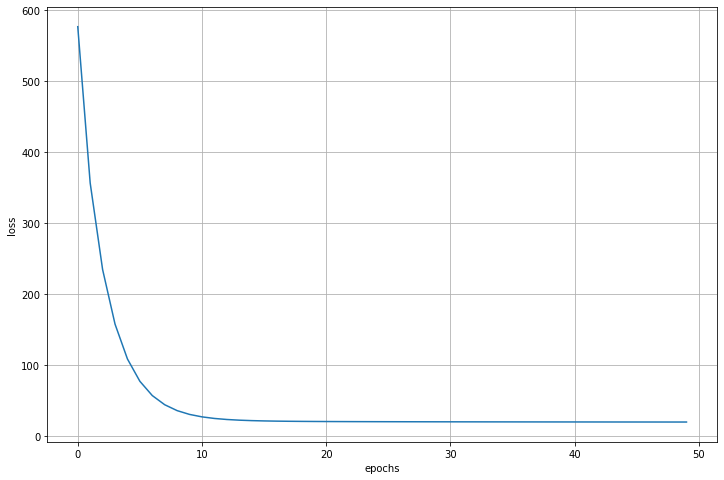

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

Come possiamo vedere, la loss converge dopo circa $15$ epoche, portando a un valore stabile intorno alle $20$ unità. Tuttavia stiamo ragionando solo sulla loss di training, per cui non sappiamo ancora se il modello generalizza. Calcoliamo il valore della loss sul test set:

In [23]:
#iniziamo calcolando le predizioni del modello dati i pesi allenati
yt = linear_regression(X_testing_norm,theta,theta_0)
#calcoliamo il valore della loss
print(loss(yt, Y_testing))

tensor(42.8920, grad_fn=<MeanBackward0>)


La loss ottenuta è circa doppia rispetto a quella di training. Ciò indica che c'è un certo livello di overfitting. Per capire se anche la loss di test converge, sarebbe interessante seguirne l'evoluzione durante il training. Modifichiamo il codice di training visto sopra per includere il calcolo e salvataggio della loss di test:

In [24]:
lr = 0.1
epochs = 50

# Passo 1: normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

#Passo 2: inizializziamo i pesi come visto in precedenza
theta = torch.Tensor(13); 
theta_0 = torch.Tensor(1); 
theta.normal_(0,0.01) 
theta_0.normal_(0,0.01)

theta.requires_grad_(True)
theta_0.requires_grad_(True)

losses_train = []
losses_test = []

for e in range(epochs):
    #Passo 3: calcoliamo le predizioni
    y = linear_regression(X_training_norm,theta,theta_0)
    
    #Passo 4: calcoliamo il valore della loss
    l = loss(y, Y_training)
    
    #conserviamo il valore della loss di training
    losses_train.append(l.item())
    
    #Passo 5: calcoliamo il gradiente della loss rispetto a tutti i parametri
    l.backward()
    
    #Passo 6: Aggiorniamo i pesi
    theta.data.sub_(lr*theta.grad.data)
    theta_0.data.sub_(lr*theta_0.grad.data)
    
    #azzeriamo i gradienti per evitare di accumularli
    theta.grad.data.zero_()
    theta_0.grad.data.zero_()
    
    #calcoliamo la loss sul test set
    #dato che non dobbiamo calcolare i gradienti
    #li disabilitiamo per risparmiare memoria
    with torch.set_grad_enabled(False):
        y_test = linear_regression(X_testing_norm, theta, theta_0)
        loss_test = loss(y_test, Y_testing)
        losses_test.append(loss_test.item())

Adesso stampiamo i valori delle loss:

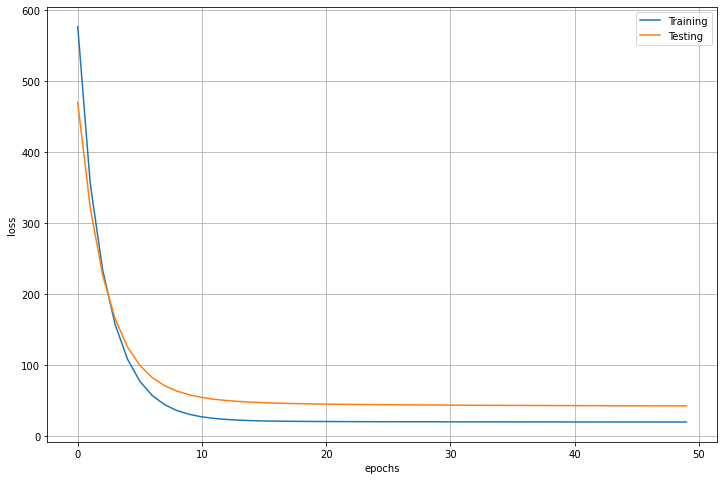

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend(['Training','Testing'])
plt.show()

Possiamo osservare che anche la loss di test converge, sebbene a un valore più alto di quella di training.

**Domanda 5**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Continuare ad allenare il modello per più epoche potrebbe verosimilmente diminuire la loss di test? Perché?

**Risposta 5**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# 2 API ad Oggetti di PyTorch

Abbiamo visto come costruire e allenare un regressore lineare mediante PyTorch. Per velocizzare e semplificare la scrittura del codice, PyTorch mette a disposizione una potente API ad oggetti che favorisce il riutilizzo del codice e permette di implementare gli algoritmi in maniera veloce ed efficiente. Vediamo di seguito come implementare un regressore lineare sfruttando la potenza dell'API ad oggetti di PyTorch.

## 2.1 Modulo `Linear`

Iniziamo dicendo che, in PyTorch, ogni pezzo di codice che effettua della computazione è generalmente implementato come un oggetto di tipo `Module`. Ciò include:
 * Trasfromazioni lineari del tipo $y = Ax + b$;
 * Funzioni quali la funzione logistica;
 * Loss;
 * Modelli (reti neurali) costruiti dall'utente.
 
PyTorch mette a disposizione una serie di moduli predefiniti che sono contenuti dentro `torch.nn`. Come primo esempio di modulo, vediamo l'oggetto `Linear`. Si tratta di un modulo che permette di eseguire trasformazioni lineari del tipo 
\begin{equation}
y = Ax^T + b
\end{equation}
dove:
 * x è la matrice degli elementi di input di dimensione $N \times n$, con $N$ numero dei campioni e $n$ dimensionalità di ogni elemento;
 * A è la matrice di trasformazione (detta anche matrice dei pesi) di dimensione $m \times n$, con $n$ dimensionalità dei dati in ingresso e $m$ dimensionalità dei dati in uscita;
 * b è un termine additivo (detto "bias") di dimensionalità $m$;
 * y è la matrice degli elementi di output di dimensionalità $m \times N$.

In pratica, la trasformazione lineare $y = Ax^T + b$, ci permette di trasformare i dati $n-dimensionali$ $x$ in dati $m-dimensionali$ $y$ utilizzando i parametri $A$ e $b$.

**Domanda 6**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si consideri la trasfromazione lineare $y=Ax^T + b$. Perché è necessario trasporre la matrice $x$?

**Risposta 6**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Il costruttore dell'oggetto `Linear` richiede in input (si veda la documentazione http://pytorch.org/docs/master/nn.html#torch.nn.Linear per maggiori informazioni):
 * Il numero di feature in entrata $n$;
 * Il numero di feature in uscita $m$;
 
Ad esempio, il seguente modulo permette di trasformare dati di dimensionalità $20$ in dati di dimensionalità $10$:

In [26]:
from torch import nn
linear = nn.Linear(20,10)

L'oggetto `linear` contiene al suo interno tutto il necessario per effettuare la trasformazione lineare. Possiamo accedere ai parametri interni richiamando il metodo `parameters`:

In [27]:
par = list(linear.parameters())
print(par[0].shape) # Matrice A [m x n]
print(par[1].shape) # Vettore b [m]

torch.Size([10, 20])
torch.Size([10])


Inoltre, il costruttore di `Linear` ha già inizializzato i parametri interni opportunamente:

In [28]:
print(par[0].mean(), par[0].std())
print(par[1].mean(), par[1].std())

tensor(0.0010, grad_fn=<MeanBackward0>) tensor(0.1248, grad_fn=<StdBackward0>)
tensor(-0.0378, grad_fn=<MeanBackward0>) tensor(0.1176, grad_fn=<StdBackward0>)


Ogni modulo di PyTorch è `callable`, il che significa che lo si può utilizzare esattamente come una funzione. Per effettuare la proiezione lineare definita da `linear`, possiamo dunque procedere come segue:

In [29]:
#costruiamo una matrice di 150 elementi a 20 dimensioni
sample_input = torch.rand((150,20))
#otteniamo una matrice di 150 elementi a 10 dimensioni
sample_output = linear(sample_input)
print(sample_output.shape)

torch.Size([150, 10])


C'è da notare che un regressore lineare non fa altro che effettuare una trasformazione del tipo $y=Ax+b$. In particolare, nel caso del regressore implementato sopra, abbiamo:
 * $n$: numero di feature in ingresso = 13;
 * $m$: numero di feature in uscita = 1;
 
Possiamo dunque implementare il regressore lineare visto sopra come segue:

In [30]:
linreg = nn.Linear(13,1)
z = linreg(X_training_norm)
print(z.shape)

torch.Size([456, 1])


## 2.2 Funzione di Loss

PyTorch mette a disposizione anche una serie di loss standard. La loss definita in precedente è detta anche "mean squared loss" ed è implementata dal modulo MSELoss:

In [31]:
mse = nn.MSELoss()

Confrontiamo i risultati della loss di PyTorch con quelli della nostra:

In [32]:
print("Loss di PyTorch:",mse(z,Y_training.view(-1,1)))
print("Loss implementata a mano:",loss(z,Y_training.view(-1,1)))

Loss di PyTorch: tensor(583.5790, grad_fn=<MseLossBackward>)
Loss implementata a mano: tensor(583.5790, grad_fn=<MeanBackward0>)


Benché i risultati siano identici, è sempre meglio preferire i moduli standard messi a disposizione da PyTorch quando possibile.

## 2.3 Definizione di Moduli

Ogni nuovo modello dovrebbe essere implementato in PyTorch come un modulo. Ciò ha differenti vantaggi, ad esempio:
 * Ci permette di mantenere tutti i parametri in un posto unico (l'oggetto);
 * Ci permette di strutturare l'implementazione di diversi modelli in maniera simile;
 * Ci permette di salvare e caricare facilmente modelli.
 
Per definire un nuovo modulo, dobbiamo ereditare la classe `Module` e implementare almeno i seguenti due metodi:
 * Il costruttore: specifica come bisogna costruire il modulo e inizializza gli eventuali sotto-moduli;
 * Il metodo `forward`: specifica cosa fare quando il modulo viene chiamato con `modulo(x)`.
 
Inoltre, è possibile far si che un modulo si comporti in maniera diversa nelle fasi di training e test dell'algoritmo. Ciò può essere ad esempio utile per far si che un regressore logistico restituisca le probabilità in fase di test e i logits in fase di training, in modo da poter usare la loss numericamente stabile. 

Vediamo come implementare un regressore lineare come modulo di PyTorch:

In [33]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        """Costruisce un regressore logistico.
            Input:
                in_size: numero di feature in input (es. 13)
                out_size: numero di elementi in output (es. 1)"""
        super(LinearRegressor, self).__init__() #richiamo il costruttore della superclasse
        #questo passo è necessario per abilitare alcuni meccanismi automatici dei moduli di PyTorch
        
        self.linear = nn.Linear(in_size,out_size)
        
    def forward(self,x):
        """Definisce come processare l'input x"""
        result = self.linear(x)
        
        return result

I moduli di PyTorch ci permettono di utilizzare una serie di caratteristiche automatiche. Ad esempio, è possibile ottenere la lista di tutti i parametri allenabili contenuti nel modulo come abbiamo visto nel caso degli altri moduli:

In [34]:
reg = LinearRegressor(13,1)
print(list(reg.parameters()))

[Parameter containing:
tensor([[ 0.1109, -0.2135, -0.2508, -0.2333,  0.0270, -0.0753, -0.0312,  0.2009,
          0.1694, -0.1469, -0.0047, -0.2152, -0.1842]], requires_grad=True), Parameter containing:
tensor([-0.2486], requires_grad=True)]


Per indicare che il modulo è in modalità training, bisogna invocare `module.train()`, mentre per specificare che è in modalità test, bisogna invocare `module.eval()`. Ciò permette di gestire opportunamente dei maccanismi automatici di PyTorch.

## 2.4 Optimizers

Anche la procedura di ottimizzazione viene semplificata mediante degli appositi moduli messi a disposizione da PyTorch. Noi utilizzeremo il più semplici di essi, `SGD`, che aggiorna i parametri in maniera analoga a quanto fatto a mano. Il costruttore prende in input la lista dei parametri da ottimizzare e il learning rate (maggiori informazioni qui http://pytorch.org/docs/master/optim.html#torch.optim.SGD).

Implementiamo adesso la procedura di training utilizzando il modulo appena creato. La procedura di training diventa la seguente:

1. Normalizzare i dati in ingresso $\mathbf{x}$; 
* Costruire il modulo che implementa il modello (il costruttore si preoccuperà di inizializzare i parametri);
* Mettere il modello in modalità "training";
* Calcolare l'output del modello $\hat y$;
* Calcolare il valore della loss $\mathcal{L}_\theta(\hat y,y)$;
* Calcolare il gradiente della loss rispetto ai parametri del modello $\nabla_\theta \mathcal{L}_\theta(\hat y,y)$;
* Aggiornare i pesi $\theta$ secondo la regola: $\theta = \theta - \eta \nabla_\theta \mathcal{L}_\theta(\hat y,y)$, dove $\eta$ è il learning rate (ci penserà l'optimizer);
* Ripetere i passi 4-7 fino a convergenza.

Il codice corrispondente è il seguente:

In [35]:
lr = 0.1
epochs = 100

#normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

reg = LinearRegressor(13,1)
criterion = nn.MSELoss() #la loss è spesso riferita come "criterio" di ottimizzazione

#l'optimizer vuole un riferimento ai parametri da ottimizzare
#e il learning rate
optimizer = torch.optim.SGD(reg.parameters(),lr=lr)

losses_train = []
losses_test = []

for e in range(epochs):
    #mettiamo il regressore in modalità training
    reg.train()
    output = reg(X_training_norm)
    l = criterion(output.view(-1),Y_training)
    losses_train.append(l.item())
    
    l.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    #le ultime due righe sostituiscono l'update manuale:
    #   for p in logreg.parameters():
    #       p.data.sub_(lr*p.grad.data)
    #       p.grad.data.zero_()
    
    #calcoliamo la loss di test
    #mettiamo il modello in modalità validation
    reg.eval()
    
    with torch.set_grad_enabled(False):
        y_test=reg(X_testing_norm)
        l = criterion(y_test.view(-1),Y_testing)
        losses_test.append(l.item())

**Domanda 7**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Si confronti il codice scritto sopra con il codice scritto in precedenza. Quali sono i vantaggi della nuova versione?

**Risposta 7**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

Plottiamo adesso le loss di training e testing:

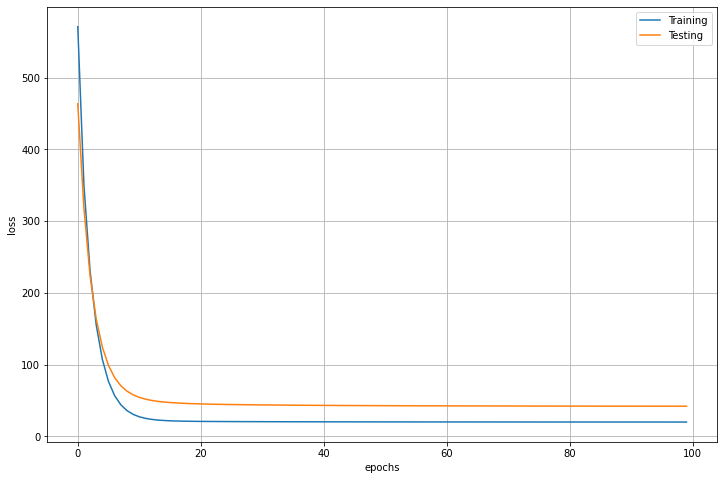

In [36]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.legend(['Training','Testing'])
plt.show()

# 3 Monitoraggio della procedura di training 

Abbiamo visto come il plot delle loss di training e test ci dia delle indicazioni su quanto la procedura di allenamento sia andata a buon fine. Abbiamo inoltre visto come visualizzare le loss di training e test appena finito il training di un modello. Con modelli più complessi del regressore lineare visto in questo laboratorio, la procedura di training può durare anche per delle ore. In tali casi può essere utile monitorare le loss e gli indicatori di performance _durante_ la procedura di allenamento. Per ottenere questo risultato utilizzeremo `tensorboard`. Tensorboard è stato progettato da Google come uno strumento per il monitoraggio delle procedure di training all'interno della libreria Tensorboard. Tuttavia, vista la sua flessibilità, PyTorch offre ormai un supporto nativo a tensorboard. I due componenti che ci servono sono i seguenti:
 * La libreria di supporto a tensorboard, parte integrante di PyTorch. Mediante questa libreria sarà possibile scrivere su disco dei file di log, che potranno essere visualizzati esternamente mediante un software di visualizzazione;
 * Il software `tensorboard`, che consiste in un server web che integra un applicativo web per la visualizzazione dei log.

Installiamo tensorboard mediante il comando `conda install tensorboard`. Creiamo a questo punto una cartella `logs` all'interno della quale andremo a scrivere i nostri file di log mediante il comando `mkdir logs`. Possiamo avviare tensorboard mediante il comando `tensorboard --logdir logs`. Questo comando dovrebbe aprire la dashboard alla porta di default `6006`. Possiamo visualizzare la dashboard inserendo il seguente URL in un browser web: http://localhost:6006/. 

Nel caso in cui si stia utilizzando Google Colaboratory, per visualizzare la dashboard di tensorboard, bisogna eseguire le seguenti istruzioni:

```
%load_ext tensorboard
%tensorboard --logdir logs```

Dato che non abbiamo ancora nessun log, dovremmo visualizzare una schermata simile alla seguente:

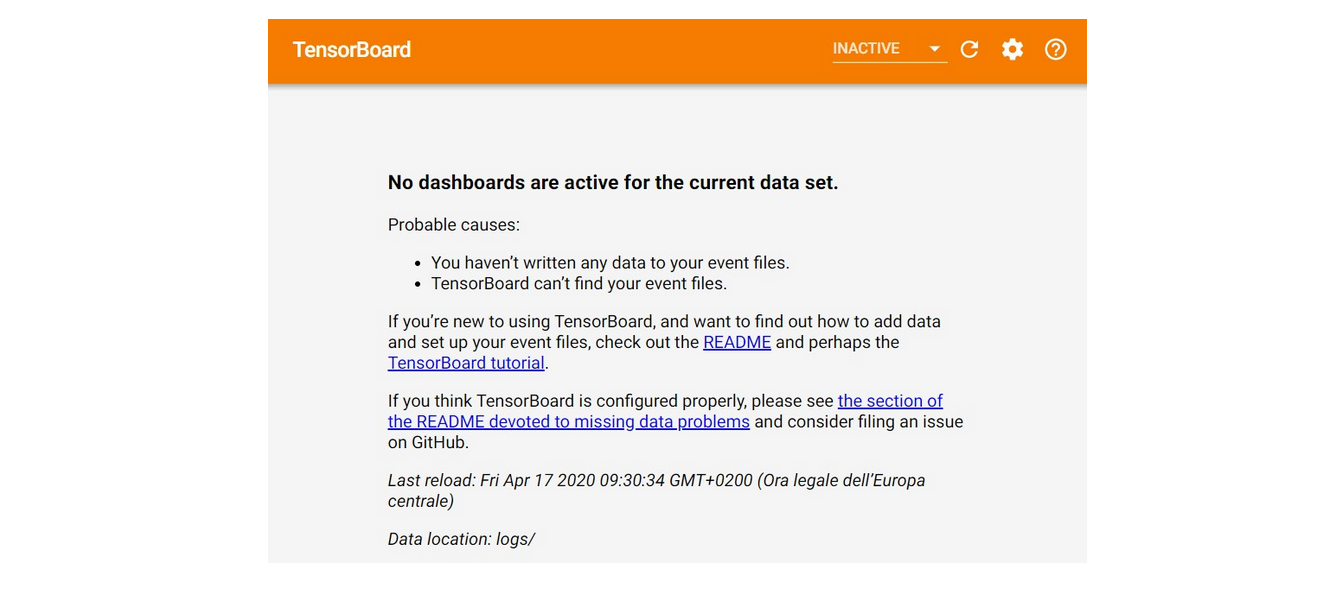

Vediamo ora come scrivere dei file di log direttamente dall'API di pytorch. Per farlo, utilizzeremo l'oggetto `SummaryWriter`. Quando costruiamo l'oggetto, dobbiamo specificare la directory in cui scrivere i log. E' buona norma inserire i log relativi a un dato esperimento in una sottodirectory della cartella contenente tutti i log. Chiamiamo questa directory "test0":

In [37]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/test0')

A questo punto possiamo iniziare ad "aggiungere" valori ai nostri log. Per inserire uno scalare (ad esempio il valore della loss ad un certo punto del training), utilizzeremo il metodo `add_scalar`. Oltre al valore dello scalare abbiamo bisogno però di specificare altri due valori:
 * Un tag che identifichi lo scalare;
 * Un intero che identifichi a che punto del training ci troviamo (chiamato `global step` da tensorboard);
 
Una convenzione generalmente utilizzata per il tag, consiste nell'utilizzare come tag il significato dello scalare (es. 'loss' o 'accuracy') seguito da una slash ('/') e da un tag che identifichi se ci troviamo in fase di training o test. Ad esempio, nel nostro caso utilizzeremo `loss/train` e `loss/test`.

Per quanto riguarda l'intero che identifichi a che punto del training ci troviamo, è spesso conveniente inserire un numero che specifichi quanto campioni sono stati "visti" in training fino a questo momento.

Iniziamo generando dei dati fittizi:

In [38]:
global_step = 0
#simuliamo un ciclo di training
for i in range(10):
    writer.add_scalar('loss/train', np.sin(global_step/5*3.14), global_step=global_step)
    global_step+=1

#simuliamo un valore di test
writer.add_scalar('loss/test', 1, global_step=global_step)

#simuliamo un secondo ciclo di training
for i in range(10):
    writer.add_scalar('loss/train', np.sin(global_step/5*3.14), global_step=global_step)
    global_step+=1
    
#simuliamo un secondo valore di test
writer.add_scalar('loss/test', 0.5, global_step=global_step)

Se aggiorniamo la pagina di tensorboard, dovremmo visualizzare qualcosa del genere:

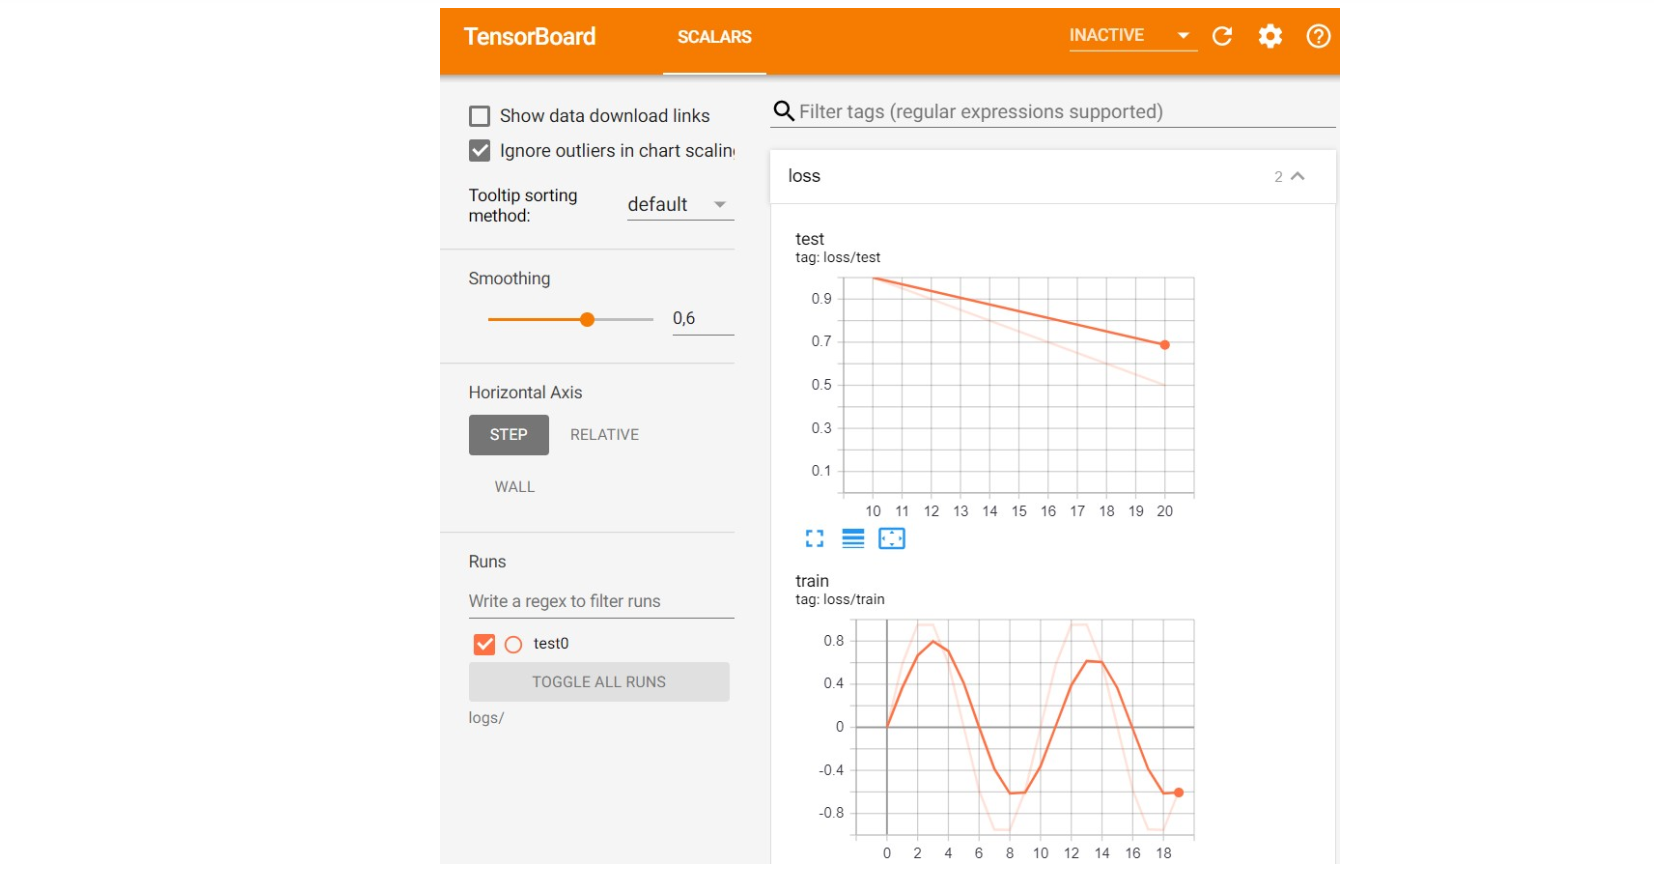

la pagina contiene diversi elementi. Vediamo i più importanti:
 * I due grafici "train" e "test" sono raggruppati in una tab "loss". Ciò è possibile per via del tag composto "loss/train" che abbiamo usato;
 * In basso a sinistra in "runs" compare una lista di esperimenti. Per il momento ne abbiamo uno solo, "test0";
 * Nella barra di sinistra, circa a metà, abbiamo un controllo "smoothing". Questo permette di approssimare ogni punto del grafico con una media calcolata considerando i valori in un intorno del punto. Questo controllo è molto utile per osservare la tendenza di uno scalare anche quando i valori sono rumorosi. Vedremo meglio come utilizzare questo controllo in seguito.

Possiamo continuare ad aggiungere punti al grafico in maniera incrementale. Ad esempio:

In [39]:
#simuliamo un ciclo di training
for i in range(10):
    writer.add_scalar('loss/train', np.sin(global_step/5*3.14), global_step=global_step)
    global_step+=1

#simuliamo un valore di test
writer.add_scalar('loss/test', 1, global_step=global_step)

#simuliamo un secondo ciclo di training
for i in range(10):
    writer.add_scalar('loss/train', np.sin(global_step/5*3.14), global_step=global_step)
    global_step+=1
    
#simuliamo un secondo valore di test
writer.add_scalar('loss/test', 0.5, global_step=global_step)

Aggiorna il grafico come segue:

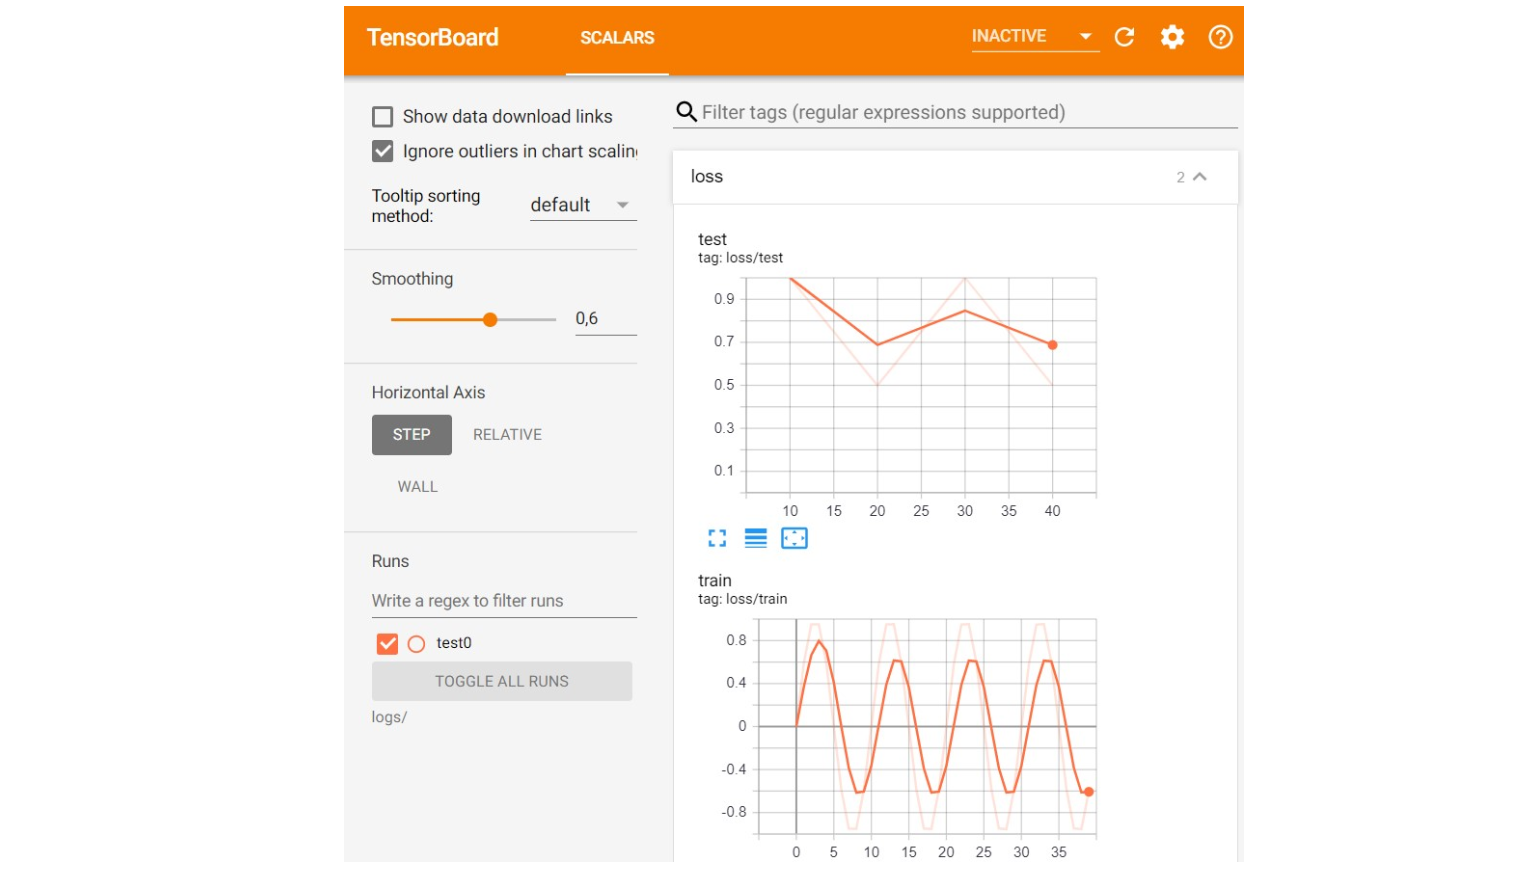

## 3.2 Esempio di logging

Modifichiamo il codice di training del regressore lineare per monitorare le loss di training e test mediante tensorboard. Faremo log dei valori ad ogni epoca e utilizzremo come "global_step" proprio il numero di epoche. Chiameremo il nostro nuovo esperimento "linear_regressor":

In [40]:
lr = 0.01
#facciamo training per 5000 epoche in modo da verificare che
#tensorboard viene aggiornato in tempo reale
epochs = 5000

writer = SummaryWriter('logs/linear_regressor')

#normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

reg = LinearRegressor(13,1)
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(reg.parameters(),lr=lr)

for e in range(epochs):
    reg.train()
    output = reg(X_training_norm)
    l = criterion(output.view(-1),Y_training)
    
    writer.add_scalar('loss/train', l.item(), global_step=e)
    
    l.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    reg.eval()
    
    with torch.set_grad_enabled(False):
        y_test = reg(X_testing_norm)
        l = criterion(y_test.view(-1),Y_testing)
        writer.add_scalar('loss/test', l.item(), global_step=e)

Facciamo training per un numero molto alto di epoche (5000) per verificare che il grafico viene effettivamente aggiornato in tempo reale. Subito dopo aver lanciato la cella sopra, passiamo a tensorboard per verificare che effettivamente il grafico viene aggiornato in tempo reale. Alla fine del training dovremmo ottenere quanto segue:

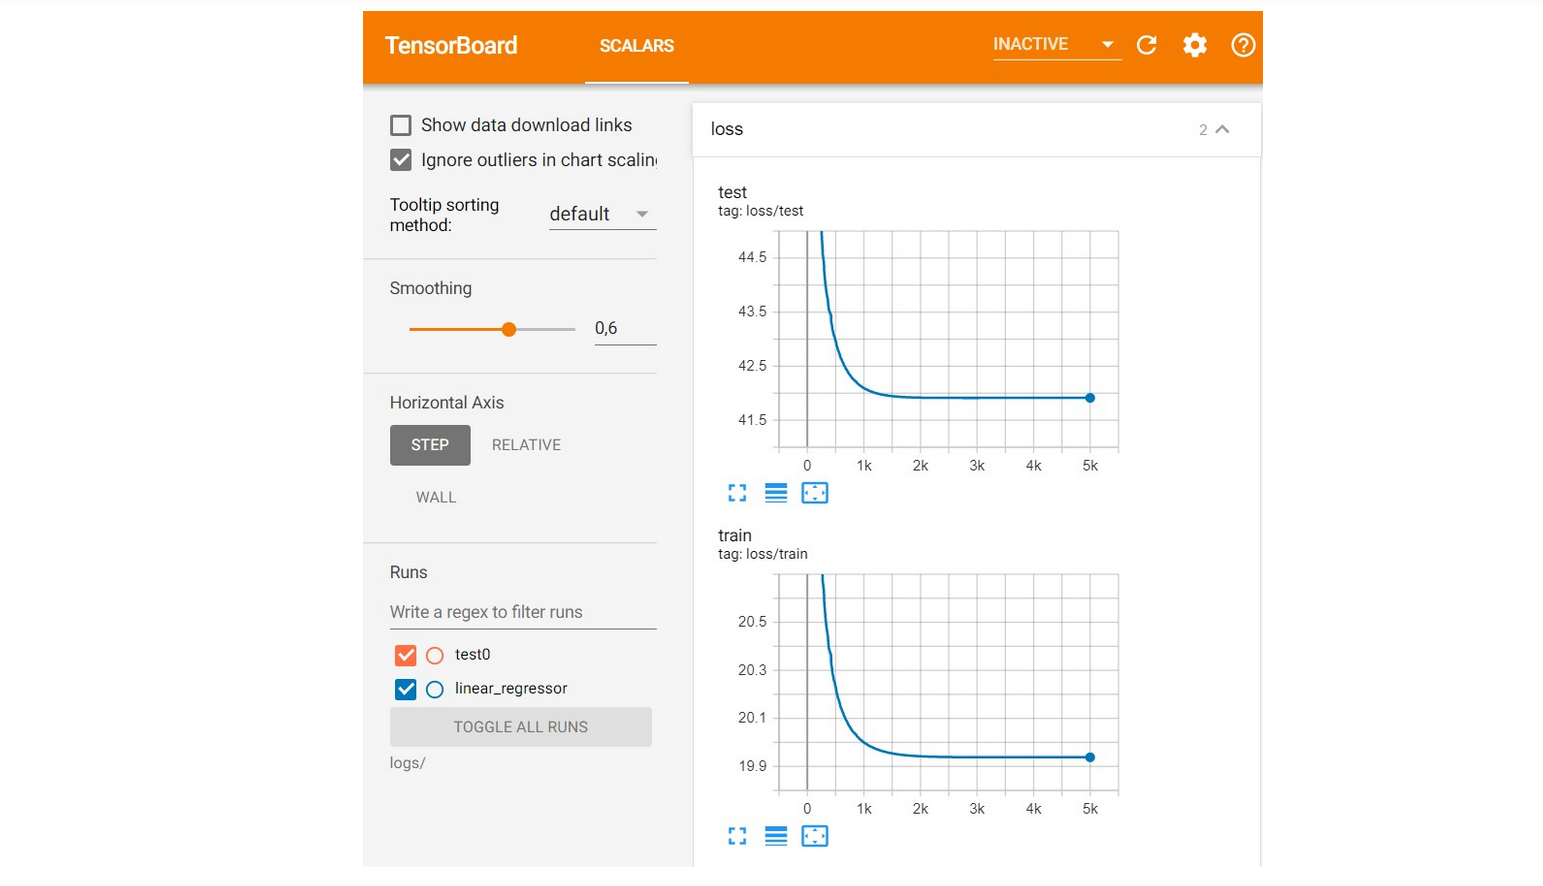

Qualora i grafici non dovessero essere mostrati correttamente, è possibile visualizzarli adattando gli assi mediante i pulsanti con le quattro frecce:

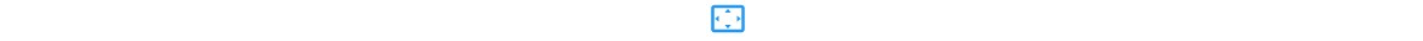

Tensorboard ci permette di confrontare il training di diversi esperimenti. Proviamo a ripetere il training cambiando il learning rate. Utilizzeremo un learning rate pari a "0.0001" e chiameremo l'esperimento `linear_regressor_lr0001`:

In [41]:
lr = 0.001
#facciamo training per 5000 epoche in modo da verificare che
#tensorboard viene aggiornato in tempo reale
epochs = 5000

writer = SummaryWriter('logs/linear_regressor_lr0001')

#normalizzazione dei dati
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

reg = LinearRegressor(13,1)
criterion = nn.MSELoss()

optimizer = torch.optim.SGD(reg.parameters(),lr=lr)

for e in range(epochs):
    reg.train()
    output = reg(X_training_norm)
    l = criterion(output.view(-1),Y_training)
    
    writer.add_scalar('loss/train', l.item(), global_step=e)
    
    l.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    reg.eval()
    
    with torch.set_grad_enabled(False):
        y_test = reg(X_testing_norm)
        l = criterion(y_test.view(-1),Y_testing)
        writer.add_scalar('loss/test', l.item(), global_step=e)

Per visualizzare meglio i grafici deselezioniamo "ignore outliers in chart scaling" e adattiamo gli assi per ogni grafico. Deselezioniamo `test0` che non è comparabile. Otterremo qualcosa del genere:

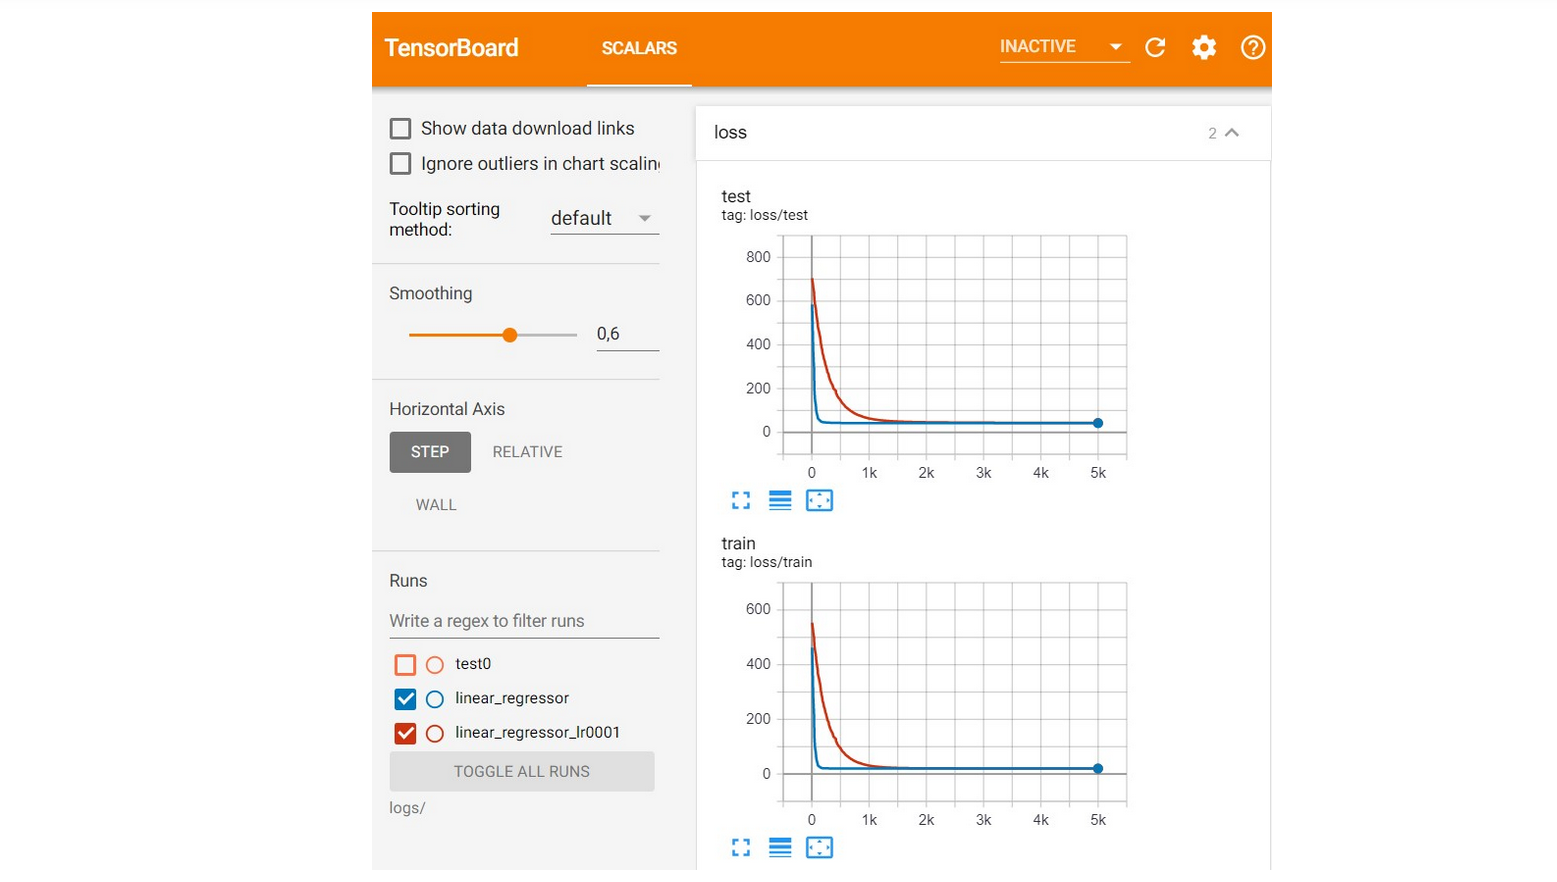

**Domanda 8**
<img src="img/qmark.jpg" style="width:150px; float:left;"/>

Cosa possiamo dire dal confronto dei due grafici? Quale dei due modelli converge prima? Perché? Era sufficiente un numero minore di epoche per il training?

**Risposta 8**
<img style="float: left;width:150px;" src="img/note.png">

<div style="background-color:#efefef; margin-left:150px; border:solid 1px; border-color:#dddddd; border-radius: 3px;">
<br><br><br><br><br><br>
</div>

# Esercizi

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 1</b>

Si provi ad allenare il regressore sul dataset Boston **senza** effettuare la normalizzazione dei dati. Se necessario, si modifichino il learning rate e il numero di epoche per portare il modello a convergenza. Si notano differenze durante il training? Il modello allenato è migliore o peggiore? Si monitorino le curve di training e test mediante tensorboard.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 2</b>

Abbiamo visto come allenare un modello di regressione lineare in maniera imperativa. Per semplificare l'utilizzo del modello, si cotruisca una classe `LinearRegressor` con i seguenti metodi:
 * Costruttore: prende in input il numero di dimensioni in input $D$ e il numero di dimensioni in output. Il costruttore inizializza i pesi del modello (theta e theta_0);
 * Metodo `fit`: prende in input i dati $X$ e le etichette $Y$ per effettuare il training. Il metodo prende in input anche i parametri `lr` e `epochs` che indicano il learning rate e il numero di epoche. I valori di default per questi due parametri sono rispettivamente $0.01$ e $100$. Il metodo `fit` calcola medie e deviazioni standard di $X$ e conserva tali valori per usi futuri, normalizza i dati $X$ ed effettua l'allenamento del modello. Ad ogni epoca, viene stampato il valore della loss;
 * Metodo `predict`: prende in input i dati $X$. Il metodo normalizza i dati $X$ utilizzando le medie e le deviazioni standard precedentemente salvate, poi predice e restituisce le etichette predette dal modello sui dati $X$;
 * Metodo `score`: prende in input i dati $X$ e le etichette $Y$. Il metodo utilizza `predict` per predire le etichette a partire dai dati $X$, poi calcola e restituisce il valore della loss calcolata utilizzando le etichette predette e le etichette fornite $Y$;
 
E' possibile inserire altri metodi privati (devono iniziare per `_`, ad esempio `_loss`) per rendere la computazione modulare.

Utilizzare l'oggetto per:
 * Allenare il modello di regressione lineare sui dati di training;
 * Calcolare la loss di training mediante il metodo `score`;
 * Predire le etichette di test mediante il metodo `predict`;
 * Calcolare la loss di test mediante il metodo `score`.

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 3</b>

Si consideri il dataset disponibile al seguente URL:

https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

Si costruisca un regressore lineare che predica i valori target a partire dagli altri attributi. Si provino diversi learning rate e numeri di epoche per far convergere il modello. Cosa succede nel caso di learning rate molto alti? E nel caso di learning rate molto bassi?

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 4</b>

Si consideri il dataset visto nell'esercizio precedente. Si costruisca un regressore lineare per predire i valori delle variabili `S1`, `S2`, `S3` a partire dai valori delle altre variabili. Per costruire il regressore, si specifichi `3` come numero di dimensioni in uscita. Si faccia attenzione al processo di normalizzazione dei dati. In questo caso, i valori delle variabili `S1`, `S2`, `S3` **non deve essere normalizzato**. Qual è la loss finale sul test set?

<img src="img/code.png" style="width:150px; margin-right:30px; float:left">
<b>Esercizio 5</b>

Qualora necessario, è possibile eliminare selettivamente uno degli esperimenti per i quali abbiamo effettuato log mediante tensorboard, in modo che questi non vengano più visualizzati nella lista dei "runs". Questo è comodo quando gli esperimenti da comparare diventano tanti e alcuni di essi non sono rilevanti. Come facciamo ad eliminare gli esperimenti? Si esplori il contenuto della cartella `logs` e si facciano delle prove per rispondere alla domanda.

# References

 * Documentazione di PyTorch. http://pytorch.org/docs/stable/index.html;
 * Documentazione relativa all API per tensorboard messa a disposizione da PyTorch. https://pytorch.org/docs/stable/tensorboard.html